First we have to download and install the pip package

In [ ]:
!pip3 install -U ncps pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import numpy as np
import torch.nn as nn
from ncps.wirings import AutoNCP
from ncps.torch import LTC
import pytorch_lightning as pl
import torch
import torch.utils.data as data

For the training we will use Pytorch-Lightning, thus we have to define our learner module.

In [ ]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)


Next we define some toy dataset and create the corresponding DataLoaders

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/ozone/eighthr.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/ozone/eighthr.names

!wget https://archive.ics.uci.edu/ml/machine-learning-databases/ozone/onehr.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/ozone/onehr.names

!wget https://github.com/aaakashkumar/Ozone-Level-Detection/raw/master/eighthr.csv

Жесткий preprocessing (https://github.com/aaakashkumar/Ozone-Level-Detection/blob/master/DSDA_Project_%E2%80%94_Ozone_Level_Detection.ipynb)

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('eighthr.csv')
df_original = pd.read_csv('eighthr.csv')
df.drop(columns='Date', inplace=True)
df.replace(to_replace='?', value=np.nan, inplace=True)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df = pd.DataFrame(imputer.fit_transform(df), dtype='float64')
df.columns = ['WSR0','WSR1','WSR2','WSR3','WSR4','WSR5','WSR6','WSR7','WSR8','WSR9','WSR10','WSR11','WSR12','WSR13','WSR14','WSR15','WSR16','WSR17','WSR18','WSR19','WSR20','WSR21','WSR22','WSR23','WSR_PK','WSR_AV','T0','T1','T2','T3','T4','T5','T6','T7','T8','T9','T10','T11','T12','T13','T14','T15','T16','T17','T18','T19','T20','T21','T22','T23','T_PK','T_AV','T85','RH85','U85','V85','HT85','T70','RH70','U70','V70','HT70','T50','RH50','U50','V50','HT50','KI','TT','SLP','SLP_','Precp','Result']
# check if NaN values exist
if np.nan in df['T_PK'].values.tolist():
  print("NaN values found")
else:
  print("No NaN values found")
# Splitting the dataset into feature(X) and target(Y)
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
# Cleaning data using Imputer Class
X = imputer.fit_transform(X)
# check if NaN values exist
if np.nan in df['T_PK'].values.tolist():
  print("NaN values found")
else:
  print("No NaN values found")

No NaN values found
No NaN values found


Жесткий Visualizattoin (https://github.com/aaakashkumar/Ozone-Level-Detection/blob/master/DSDA_Project_%E2%80%94_Ozone_Level_Detection.ipynb)

<ipython-input-6-42be5c7e4104>:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['T_PK'], ax=ax1, shade=True, color='steelblue')
<ipython-input-6-42be5c7e4104>:46: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['T_PK'], ax=ax1, shade=True, color='steelblue')


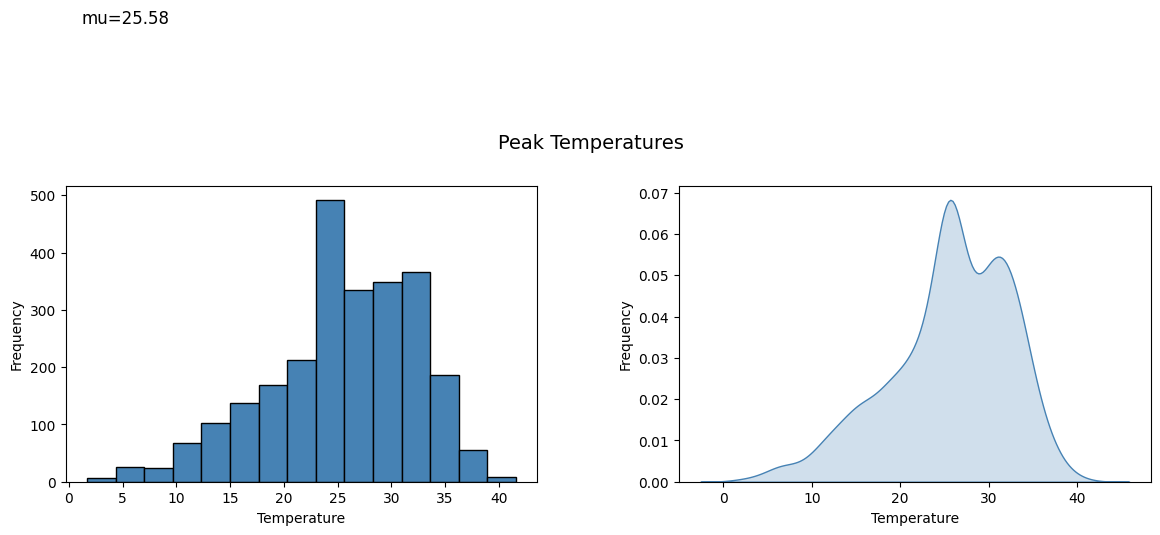

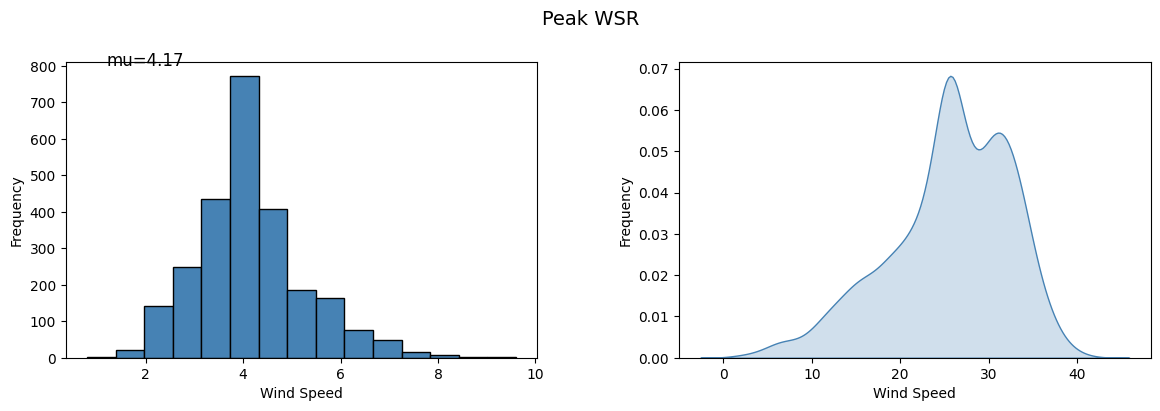

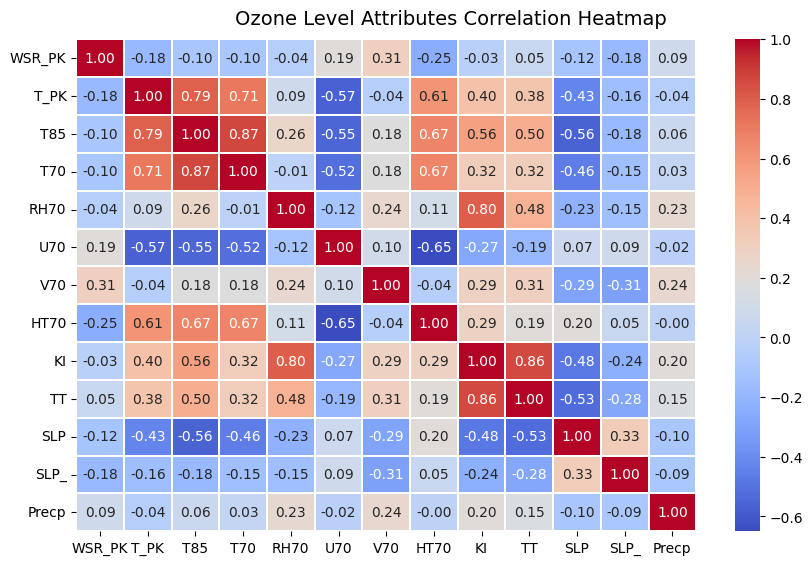

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

fig = plt.figure(figsize = (14,4))
title = fig.suptitle("Peak Temperatures", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

# Histogram
ax = fig.add_subplot(1,2, 1)
ax.set_xlabel("Temperature")
ax.set_ylabel("Frequency")
ax.text(1.2, 800, 'mu='+str(round(df['T_PK'].mean(),2)),
         fontsize=12)
freq, bins, patches = ax.hist(df['T_PK'], color='steelblue', bins=15,
                                    edgecolor='black', linewidth=1)


# Density Plot
ax1 = fig.add_subplot(1,2, 2)
ax1.set_xlabel("Temperature")
ax1.set_ylabel("Frequency")
sns.kdeplot(df['T_PK'], ax=ax1, shade=True, color='steelblue')

fig = plt.figure(figsize = (14,4))
title = fig.suptitle("Peak WSR", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

# Histogram
ax = fig.add_subplot(1,2, 1)
ax.set_xlabel("Wind Speed")
ax.set_ylabel("Frequency")
ax.text(1.2, 800, 'mu='+str(round(df['WSR_PK'].mean(),2)),
         fontsize=12)
freq, bins, patches = ax.hist(df['WSR_PK'], color='steelblue', bins=15,
                                    edgecolor='black', linewidth=1)


# Density Plot
ax1 = fig.add_subplot(1,2, 2)
ax1.set_xlabel("Wind Speed")
ax1.set_ylabel("Frequency")
sns.kdeplot(df['T_PK'], ax=ax1, shade=True, color='steelblue')

# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(10, 6))
subset_attributes = ['WSR_PK','T_PK','T85','T70','RH70','U70','V70','HT70','KI','TT','SLP','SLP_','Precp']
corr = df[subset_attributes].corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Ozone Level Attributes Correlation Heatmap', fontsize=14)

In [ ]:
print(X.shape, y.shape)
y = y[...,None] # at least 2d tensor required
print(X.shape, y.shape)

(2534, 72) (2534,)
(2534, 72) (2534, 1)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

X = torch.Tensor(X)
y = torch.Tensor(y)
print("X.size: ", str(X.size()))
print("Y.size: ", str(y.size()))
dataloader = data.DataLoader(
    data.TensorDataset(X, y), batch_size=1, shuffle=True, num_workers=4
)

X.size:  torch.Size([2534, 72])
Y.size:  torch.Size([2534, 1])


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Here we can finally create a LTCCell and make use of the predefined sparse wiring structures of the keras-ncp package. For simplicity we will just define a fully-connected RNN

In [ ]:
out_features = y.shape[-1]
in_features = X.shape[-1]
wiring = AutoNCP(16, out_features)  # 16 units, 1 motor neuron

ltc_model = LTC(in_features, wiring, batch_first=True)
learn = SequenceLearner(ltc_model, lr=0.01)
# trainer = pl.Trainer(
#     logger=pl.loggers.CSVLogger("log"),
#     max_epochs=400,
#     gradient_clip_val=1,  # Clip gradient to stabilize training
#     gpus=0,
# )

# Instead of using gpus, use devices and accelerator
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=60,
    gradient_clip_val=1,  # Clip gradient to stabilize training
    accelerator="gpu", # or 'gpu' if a GPU is available
    devices='auto' # or 'auto' to automatically detect the number of devices
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


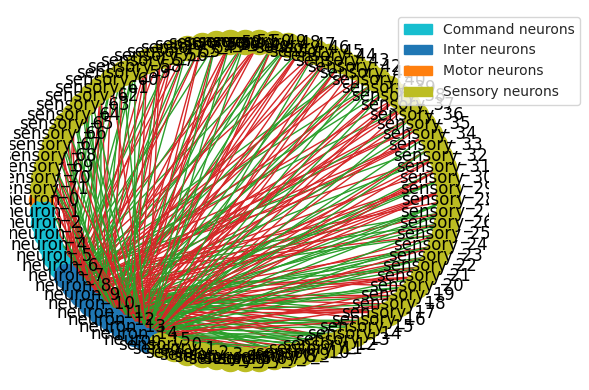

In [ ]:
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = wiring.draw_graph(draw_labels=True,  neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

In [ ]:
with torch.no_grad():
  prediction = ltc_model(X)[0].numpy()
prediction.shape

(2534, 1)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    y=y[:,0],
    mode='lines',
    name='Ground True'
))

fig.add_trace(go.Scatter(
    y=prediction[:, 0],
    mode='lines',
    name='Prediction'
))

fig.update_layout(
    title="Before training",
    xaxis_title="Observation #",
    yaxis_title="Class",
    legend=dict(x=1, y=1) # Adjust legend position if needed
)

fig.show()

... and train our network

In [ ]:
trainer.fit(learn, dataloader)

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | LTC  | 7.2 K  | train
---------------------------------------
5.8 K     Trainable params
1.4 K     Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get D

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=60` reached.


In [ ]:
results = trainer.test(learn, dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: PossibleUserWarning:

Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.



Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │   0.055728837847709656    │
└───────────────────────────┴───────────────────────────┘

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    y=y[:,0],
    mode='lines',
    name='Ground True'
))

fig.add_trace(go.Scatter(
    y=prediction[:, 0],
    mode='lines',
    name='Prediction'
))

fig.update_layout(
    title="After training",
    xaxis_title="Index",
    yaxis_title="Value",
    legend=dict(x=1, y=1) # Adjust legend position if needed
)

fig.show()